# Imports

In [385]:
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import torch
import sklearn.manifold
import sklearn.decomposition
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [215]:
label_to_id = {v: i for i, v in enumerate(os.listdir('./images/'))}

In [256]:
path = [[emotion, os.path.join('.\\images', emotion)] for emotion in os.listdir('./images/')]

In [272]:
data = []
for p_i in [[[em, os.path.join(pt, pt_im)] for pt_im in os.listdir(pt)] for em, pt in path]:
    data += p_i

In [275]:
data = pd.DataFrame(data)
data.columns = ['label', 'filepaths']

In [276]:
paths_dataset = tf.data.Dataset.from_tensor_slices(data.filepaths)

In [233]:
# paths_dataset = tf.data.Dataset.list_files([f'{x}/*.jpg' for x in path])

In [278]:
image_dataset = paths_dataset.map(lambda x: tf.io.decode_image(tf.io.read_file(x), expand_animations=False, channels=3))
batch_image_dataset = image_dataset.batch(64)

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [285]:
backbone = transformers.AutoModel.from_pretrained('google/vit-base-patch16-224')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load tokenizer to be used with the model

In [281]:
processor = transformers.AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [289]:
features = []
with torch.no_grad():
    for image in tqdm.tqdm(batch_image_dataset):
        image = processor(image.numpy(), return_tensors='pt')['pixel_values']
        features.extend(backbone(image).pooler_output.cpu().numpy())
features = np.array(features)

  0%|          | 0/249 [00:00<?, ?it/s]

In [312]:
features.shape

(15921, 768)

In [386]:
# with open(f'fetures.pic', 'wb') as f: 
#     pickle.dump(features, f)

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [308]:
y = np.array(data['label'].map(label_to_id))

In [309]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [310]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(64)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(64)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [313]:
inputs = tf.keras.layers.Input(768)
x = tf.keras.layers.Dense(len(label_to_id))(inputs)
model = tf.keras.Model(inputs=inputs, outputs=x)

Compile the model. Choose loss and metrics.

In [314]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')

# Train the model

In [318]:
model.fit(train_dataset, validation_data=test_dataset, epochs=60)

Epoch 1/60
  1/187 [..............................] - ETA: 0s - loss: 0.9829 - accuracy: 0.6094

187/187 [==============================] - 0s 1ms/step - loss: 1.0169 - accuracy: 0.5800 - val_loss: 1.1187 - val_accuracy: 0.5378
Epoch 2/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0152 - accuracy: 0.5802 - val_loss: 1.1192 - val_accuracy: 0.5376
Epoch 3/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0136 - accuracy: 0.5811 - val_loss: 1.1197 - val_accuracy: 0.5368
Epoch 4/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0121 - accuracy: 0.5827 - val_loss: 1.1201 - val_accuracy: 0.5365
Epoch 5/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0107 - accuracy: 0.5836 - val_loss: 1.1206 - val_accuracy: 0.5363
Epoch 6/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0094 - accuracy: 0.5840 - val_loss: 1.1211 - val_accuracy: 0.5360
Epoch 7/60
187/187 [==============================] - 0s 1ms/step - loss: 1.0082 - accuracy: 0.5843 - val_loss: 1.1215 - val_accuracy: 0.5353
Epoch 8/60
187/18

# Evaluation

Evalute the model on test data.

In [333]:
predict = model.predict(X_test).argmax(axis=1)

125/125 [==============================] - 0s 689us/step


Plot confusion matrix.

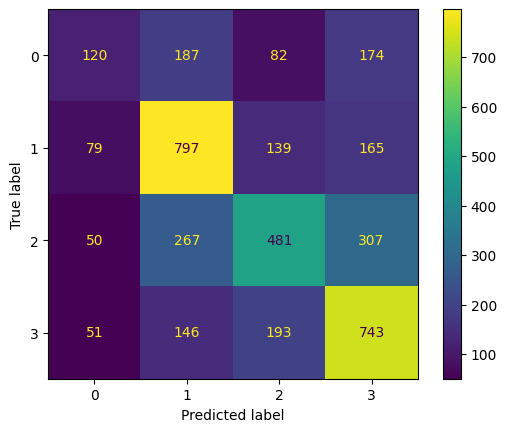

In [334]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, predict)

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

In [345]:
features.shape

(15921, 768)

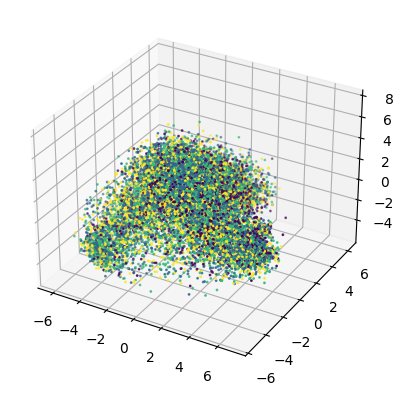

In [383]:

n = int(np.sqrt(features.shape[1]))
features2 = sklearn.decomposition.PCA(n_components=3).fit_transform(features.reshape(-1, features.shape[-1]))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(features2[:, 0], features2[:, 1], features2[:, 2], c=y, s=1)


In [384]:
features2 = sklearn.decomposition.PCA(n_components=100).fit_transform(features.reshape(-1, features.shape[-1]))

train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(64)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(64)

In [382]:
inputs = tf.keras.layers.Input(100)
x = tf.keras.layers.Dense(len(label_to_id))(inputs)
model = tf.keras.Model(inputs=inputs, outputs=x)

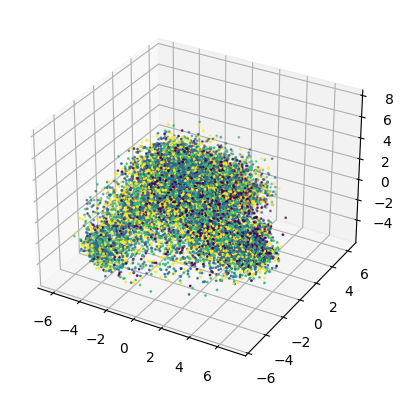

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween same in different classes)

In [406]:
len(label_to_id.values())

4

In [407]:
average_distance_in_class = np.zeros((len(label_to_id.values()), len(label_to_id.values())))
for i in tqdm.tqdm(label_to_id.values()):
    for j in tqdm.tqdm(label_to_id.values()):
        
        dist = []
        for v in tqdm.tqdm(features[y==i]):
            dist.append(((v - features[y==j]) ** 2).sum(axis = 1).mean())
    
    average_distance_in_class[i, j] = np.mean(dist)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/2256 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4784 [00:00<?, ?it/s]

  0%|          | 0/4784 [00:00<?, ?it/s]

  0%|          | 0/4784 [00:00<?, ?it/s]

  0%|          | 0/4784 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4349 [00:00<?, ?it/s]

  0%|          | 0/4349 [00:00<?, ?it/s]

  0%|          | 0/4349 [00:00<?, ?it/s]

  0%|          | 0/4349 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/4532 [00:00<?, ?it/s]

  0%|          | 0/4532 [00:00<?, ?it/s]